In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

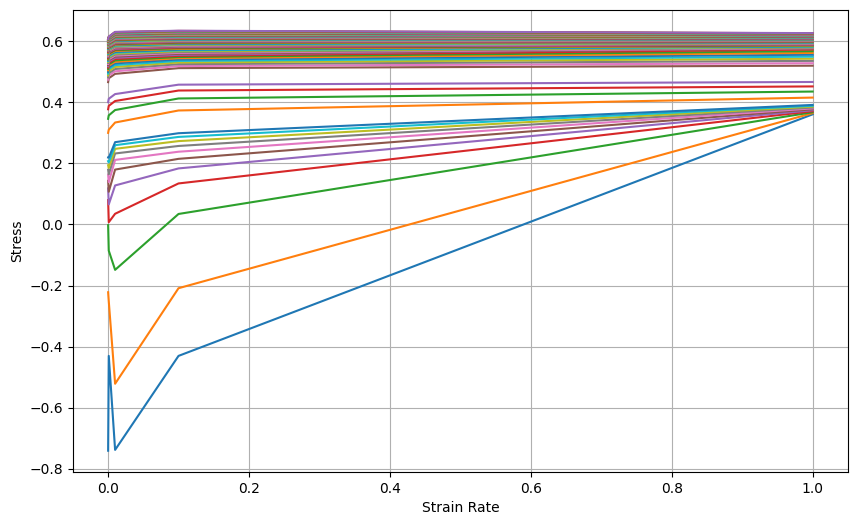

In [5]:
temp = '298.15'
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1, 1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
data = pd.read_csv(f"../Tmp{temp}_RD_fixed.csv")

plt.figure(figsize=(10,6))
for i in range(len(data)):
    # Extract stress data for each row
    stress_values = np.log(data.iloc[i][strain_rate_columns][0:5].values)
    plt.plot(strain_rates[0:5], stress_values, '-', label='Data')
    plt.xlabel('Strain Rate')
    plt.ylabel('Stress')
    plt.grid()

plt.show

In [6]:
def wagoner(strain_rate, m0, m1):
    return m0 * (np.sqrt(strain_rate * 0.0001) ** m1) * (np.log(strain_rate / 0.0001))

def estimate_m_values(data, temp, strain_rates, strain_rate_columns, plot=True):
    """
    Fits strain rate dependency for each row in a dataset and exports results.
    
    Parameters:
    - temperature_file (str): Path to the CSV file containing the data for a specific temperature.
    - strain_rates (list of float): List of strain rate values corresponding to columns in the dataset.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    
    Output:
    - CSV file with columns: PEEQ, m0, m1, R_squared for each row in the dataset.
    """

    # Default rows to plot
    plot_indices = [0,1,2,3,4]
    #3, 4, 5, 6, 11
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1

    # List to store the results
    results = []

    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):
        # Extract stress data for each row
        stress_values = data.iloc[i][strain_rate_columns].values
        stress_values = np.log(stress_values)
        bounds =  [(-5,-5), (1000,1000)]
        
        initial_guess = [-1, 0.5]
        
        # Initial guess for m0 and m1
        if temp == '298.15': 
            initial_guess = [5, 1]
        elif temp == '373.15': 
            initial_guess = [1, 0.5]
        
        # Perform the curve fitting using wagoner function
        try:
            params, _ = curve_fit(wagoner, strain_rates, stress_values, p0=initial_guess, bounds=bounds, maxfev=100000)
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        # Calculate residuals and R-squared
        stress_fit = wagoner(np.array(strain_rates), *params)
        residuals = stress_values - stress_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Store results for exporting
        results.append({
            "PEEQ": data['strain'].iloc[i],
            "m0": params[0],
            "m1": params[1],
            "R_squared": r_squared
        })
        
        plt_strain_rates = np.linspace(min(strain_rates), max(strain_rates), 1000)
        plt_stress_fit = wagoner(plt_strain_rates, *params)
        # Plot only for specified rows with scaled m0 and m1 in legend
        if i in plot_indices:
            plt.plot(strain_rates, stress_values, 'o', label='Data')
            plt.plot(plt_strain_rates, plt_stress_fit, '-', label='Fit')
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} {temp}K (R² = {r_squared:.3f})")
            plt.legend([f'Row {i}', f'Fit: m0={params[0]:.2f}, m1={params[1]:.2f}'], loc="lower right")
            plt.grid()
            plt.show()

    # Export results to CSV
    df = pd.DataFrame(results)
    df.to_csv(f"w_m_values_{temp}.csv", index=False)

    if plot:
        strain = data['strain']
        for strain_rate, col in zip(strain_rates, strain_rate_columns):
            fitted_stress = [wagoner(strain_rate, m0, m1) for m0, m1 in zip(df['m0'], df['m1'])]
            real_stress = np.log(data[col].values)

            residuals = real_stress - fitted_stress
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((real_stress - np.mean(real_stress))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            plt.plot(strain, fitted_stress, label=f'Predicted StrRt{strain_rate}')
            plt.scatter(strain, real_stress, color='red', label=f'Real StrRt{strain_rate}')
            plt.xlabel('Strain')
            plt.ylabel('Normalized Stress')
            plt.title(f'Real vs Predicted Stress for StrRt{strain_rate} {temp}K  (R² = {r_squared:.3f})')
            plt.legend()
            plt.show()

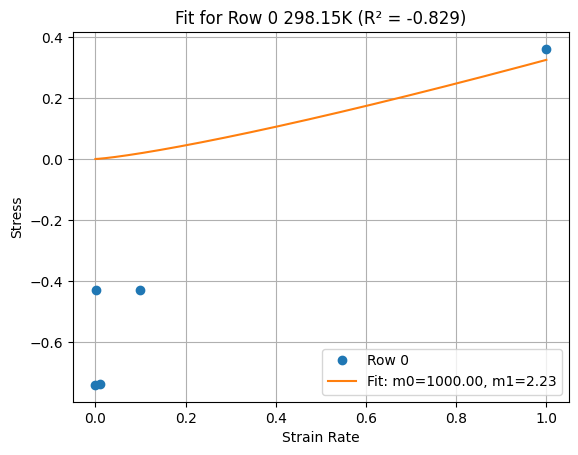

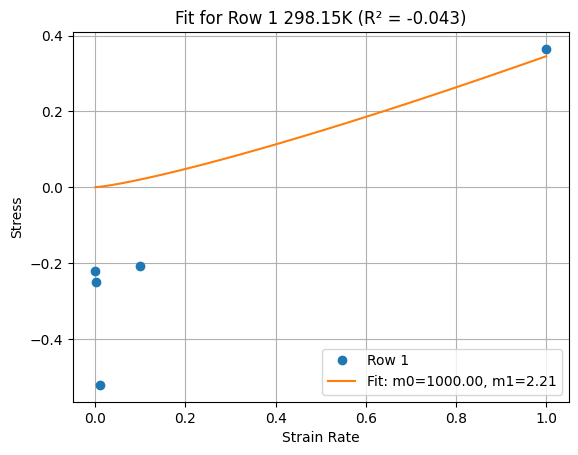

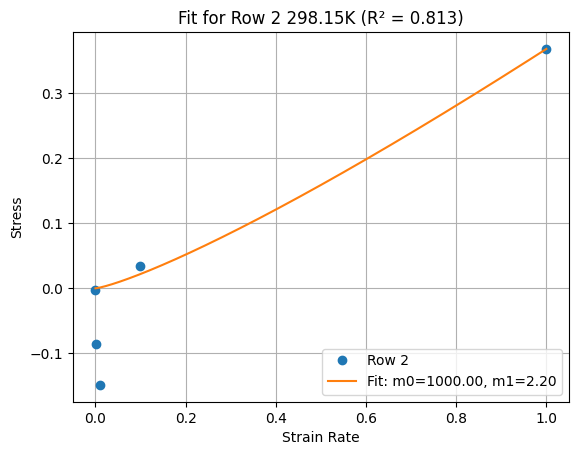

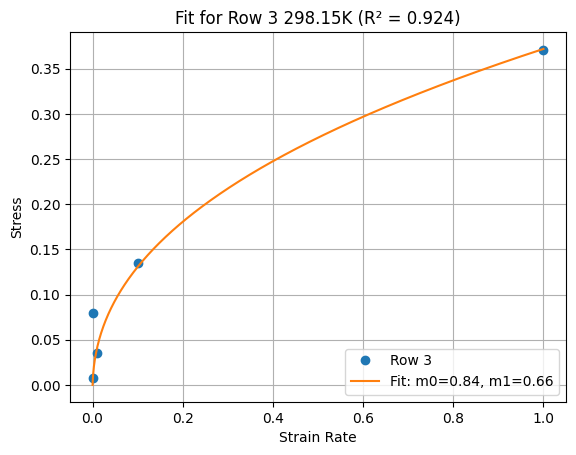

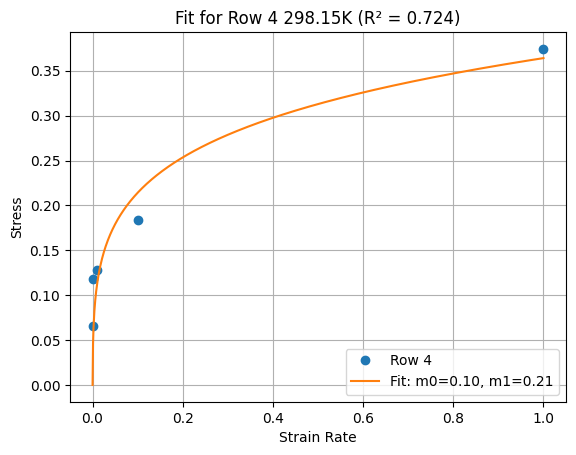

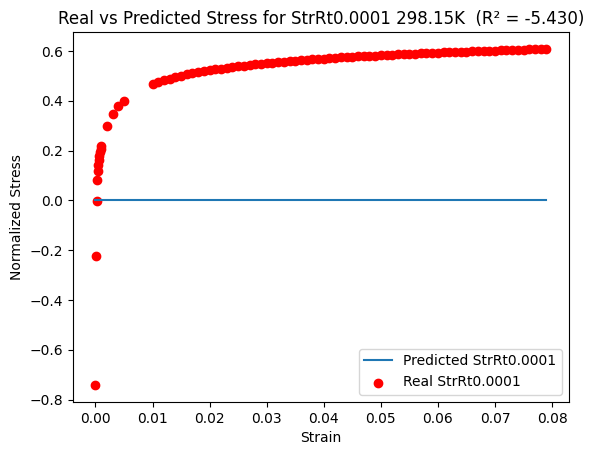

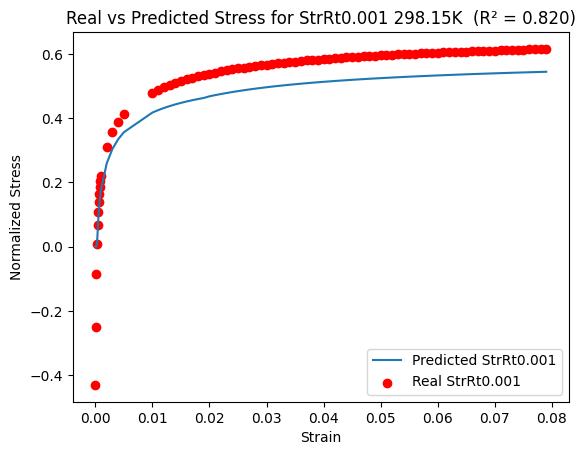

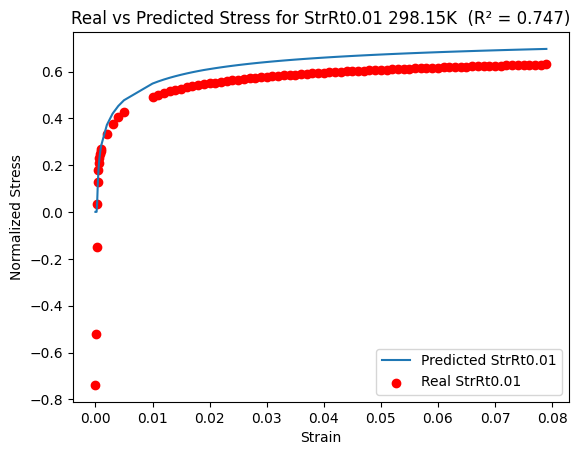

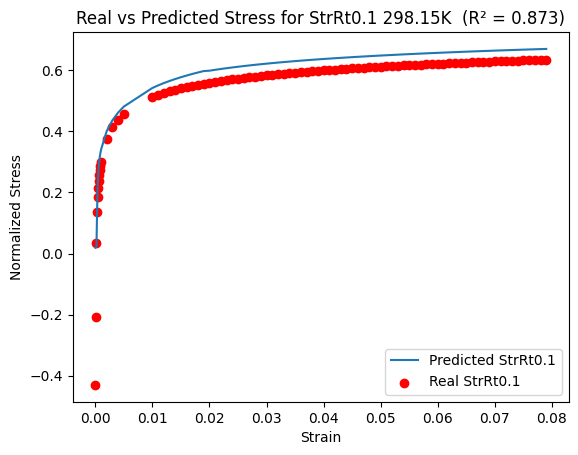

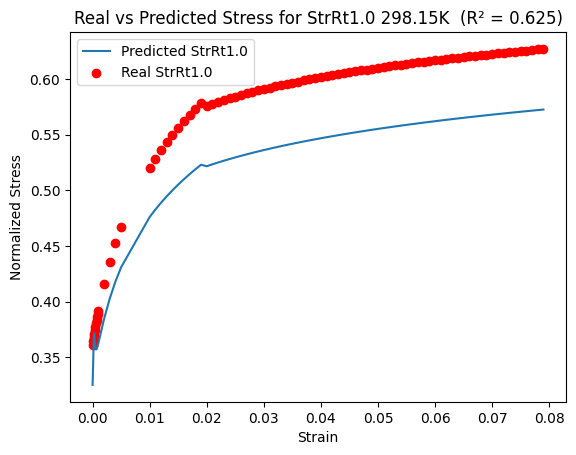

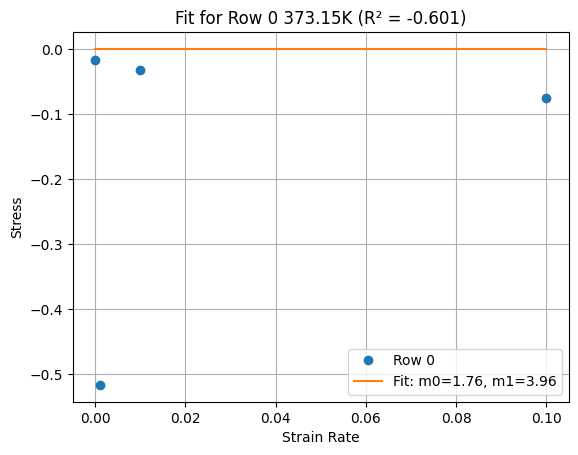

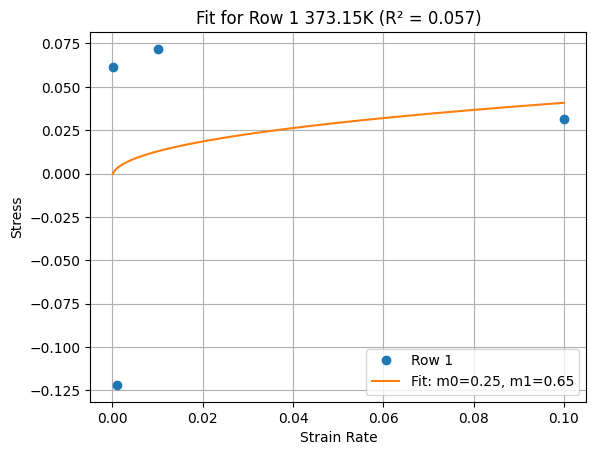

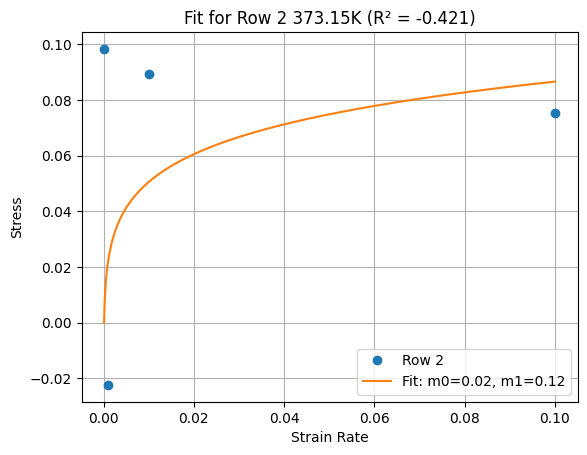

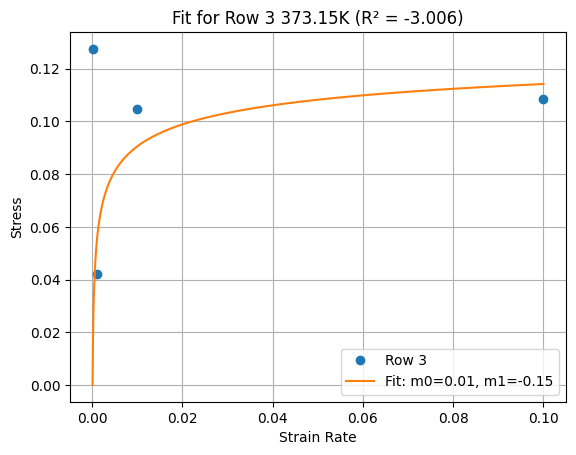

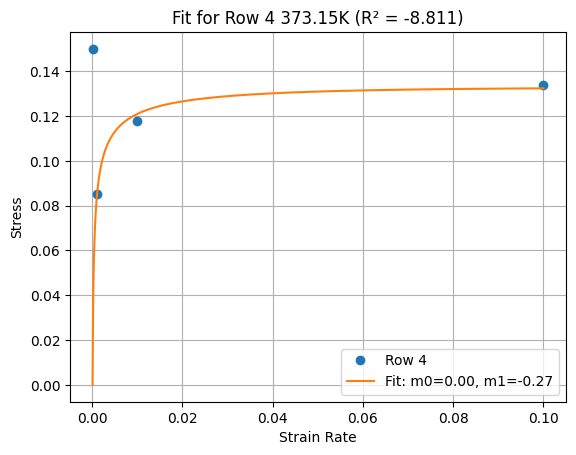

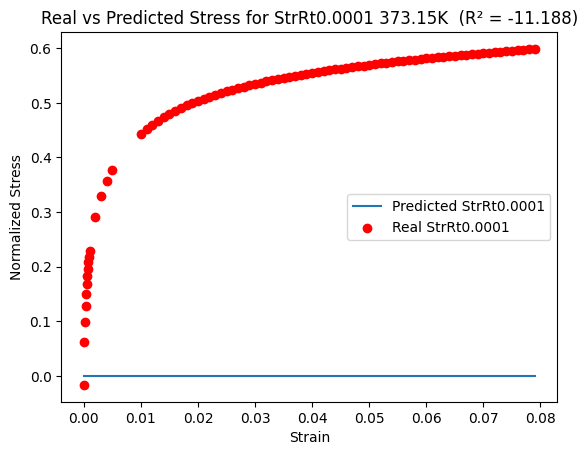

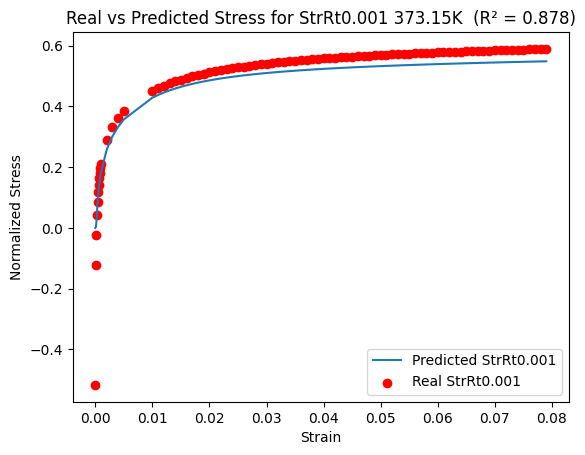

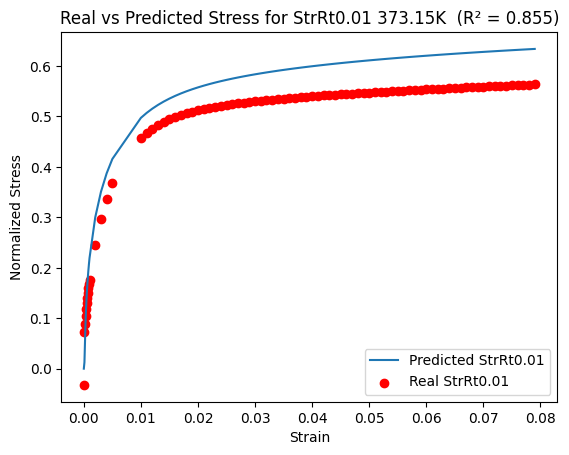

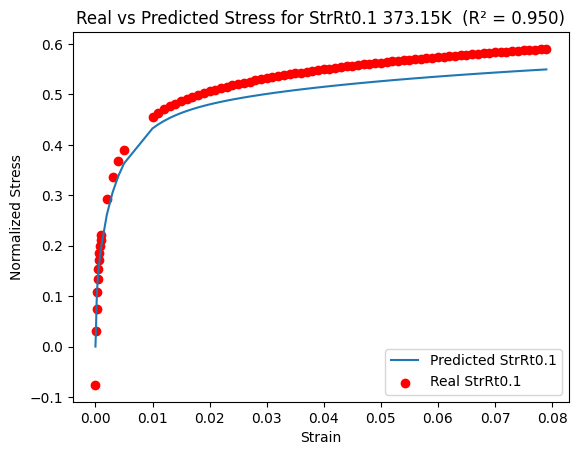

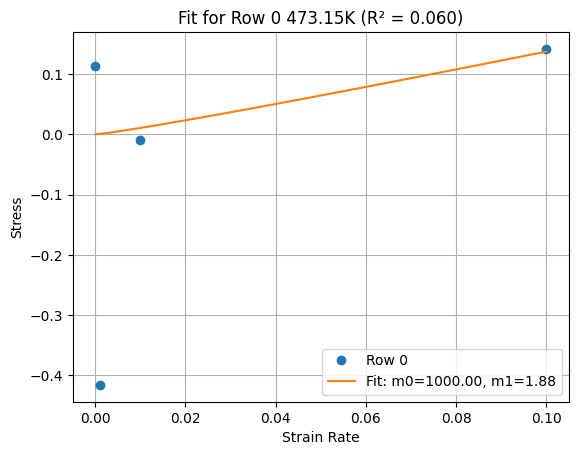

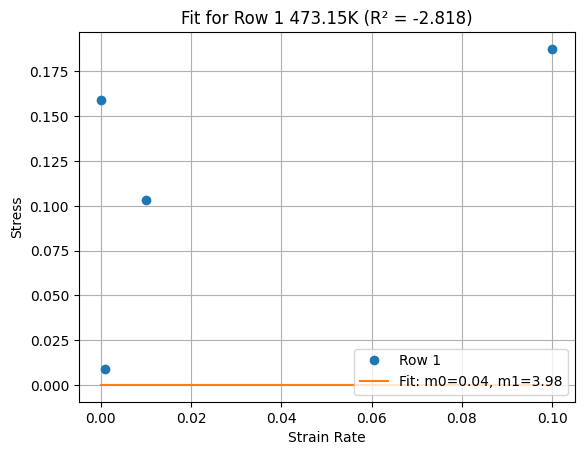

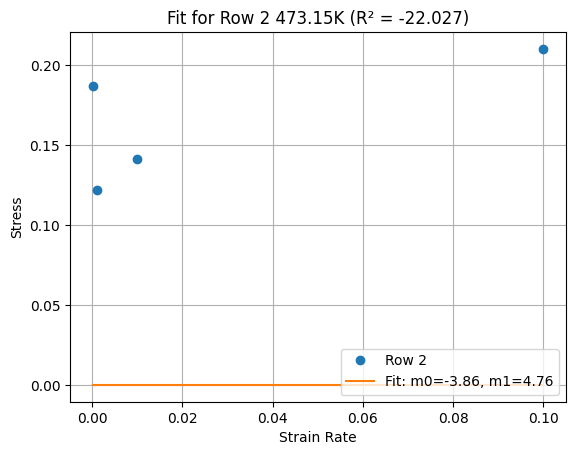

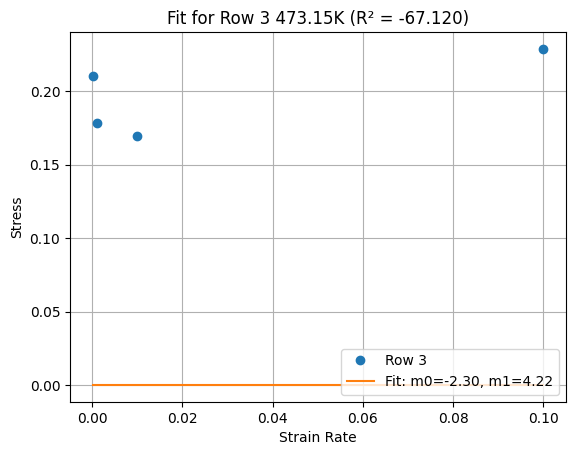

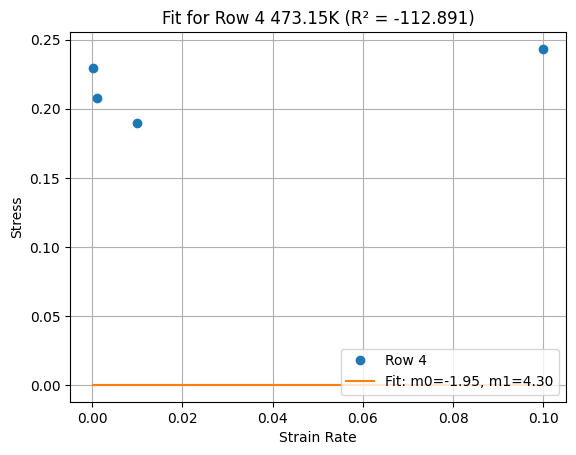

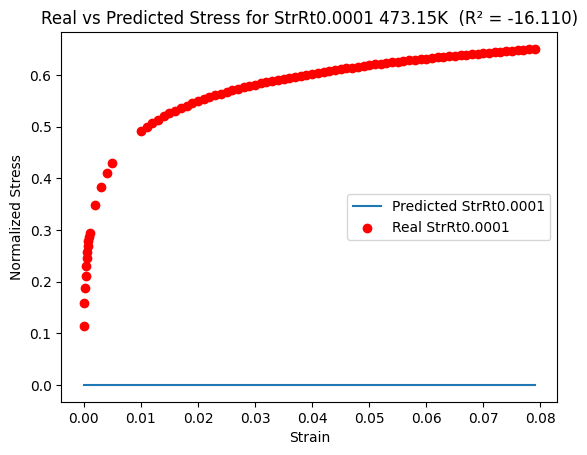

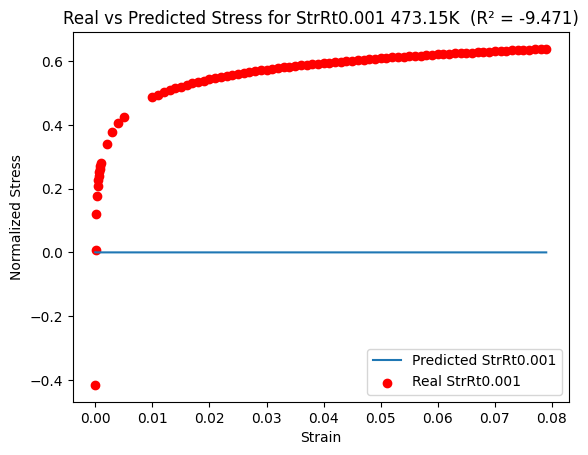

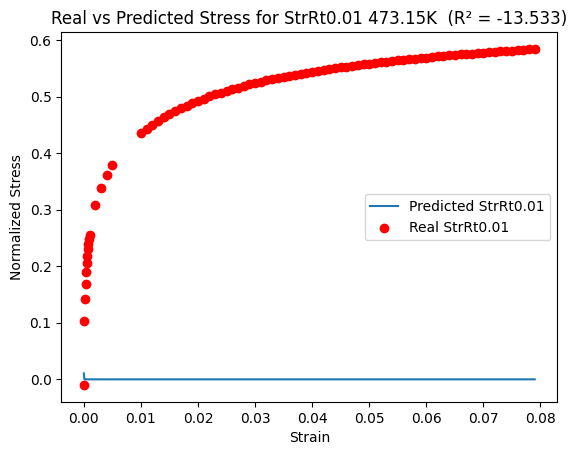

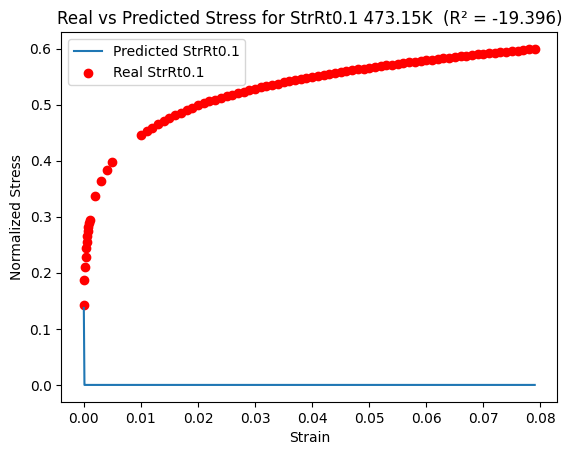

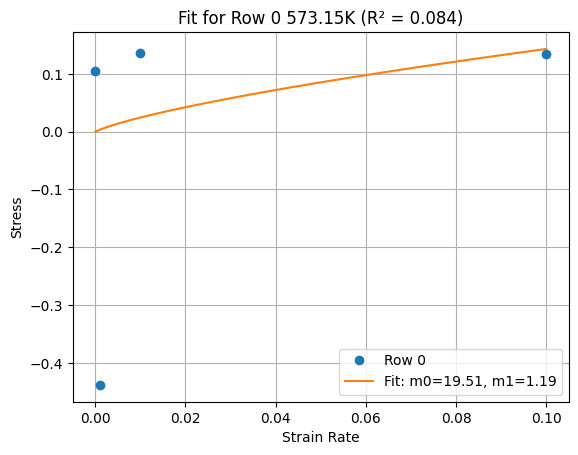

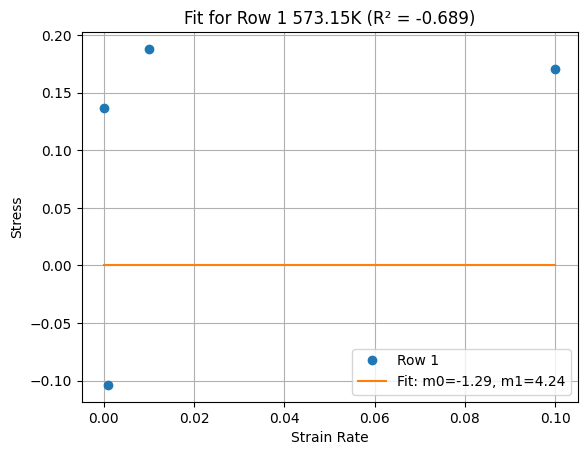

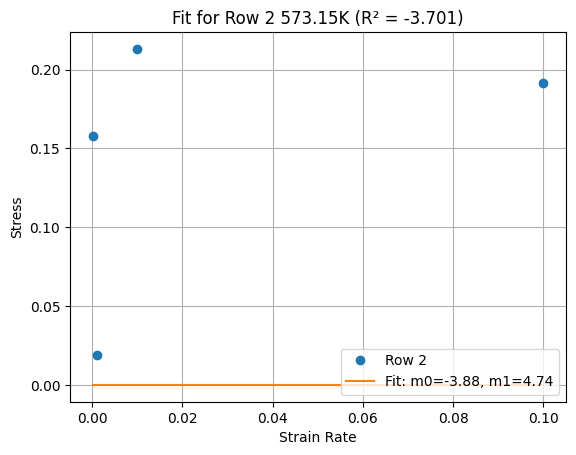

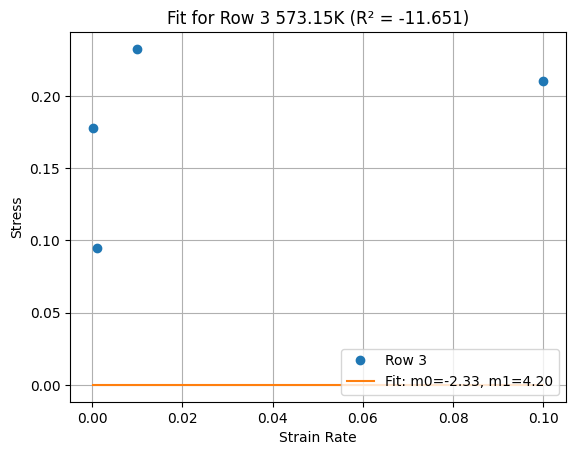

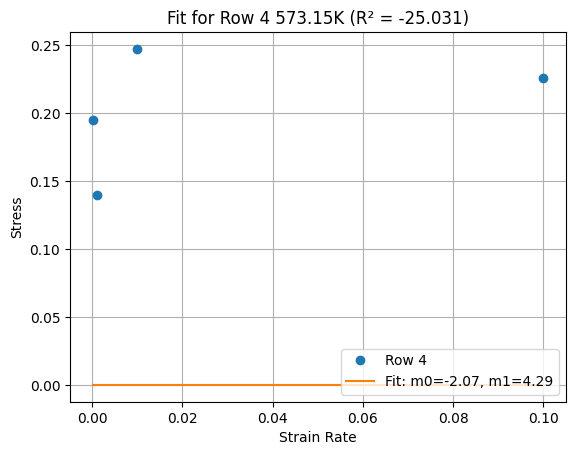

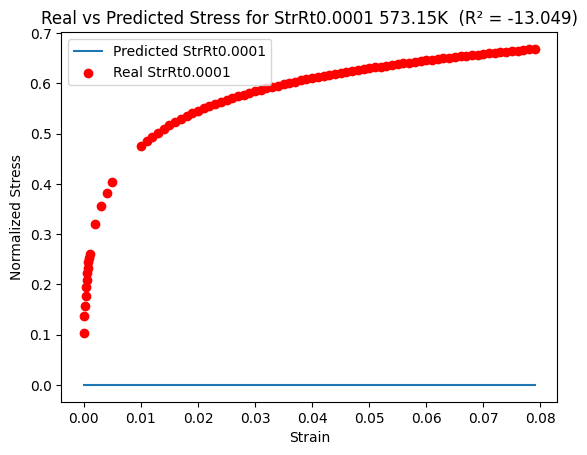

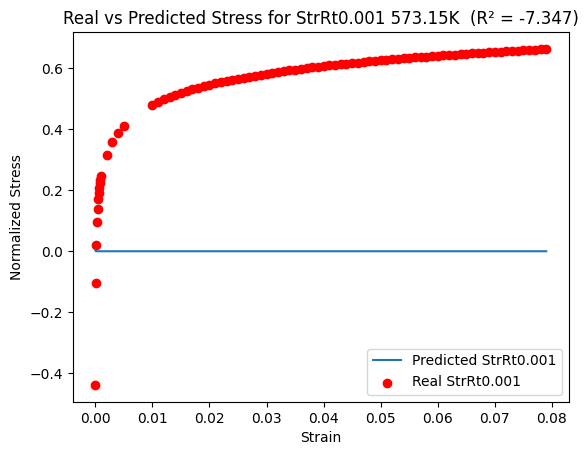

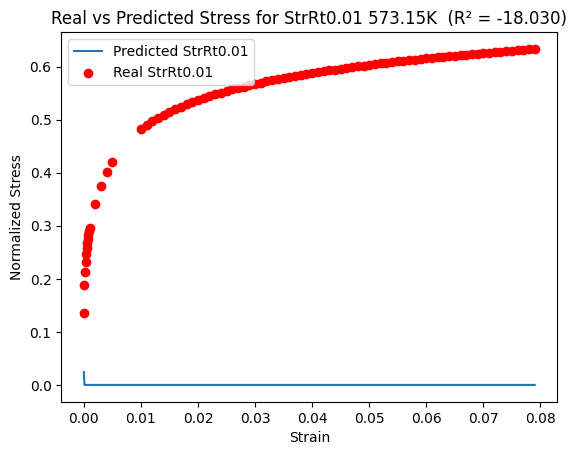

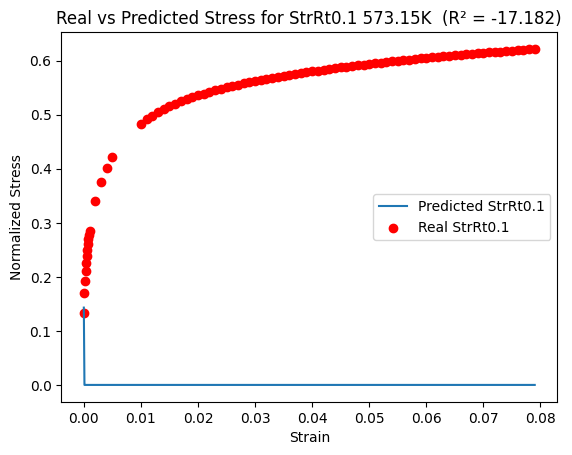

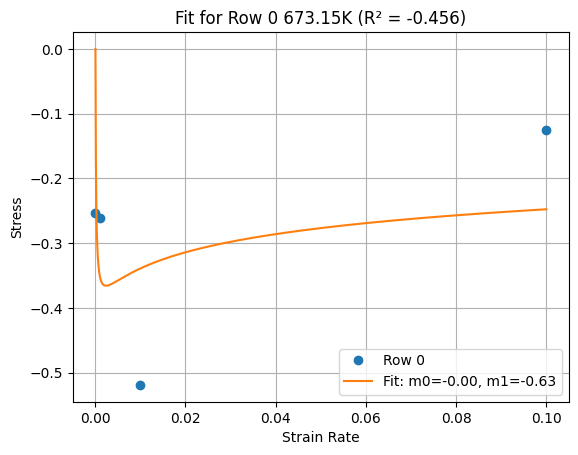

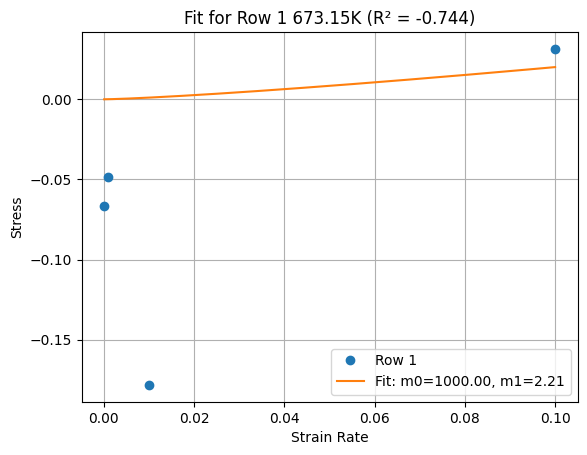

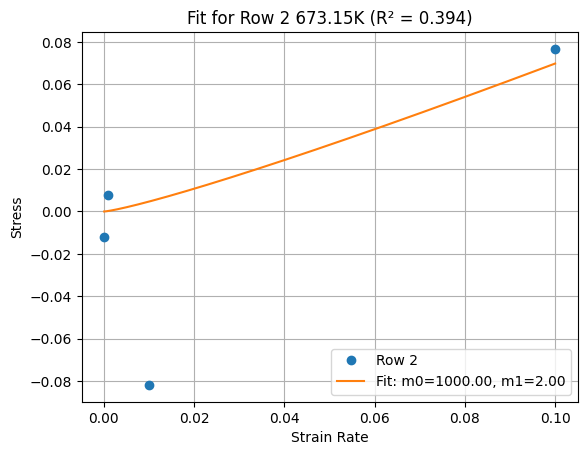

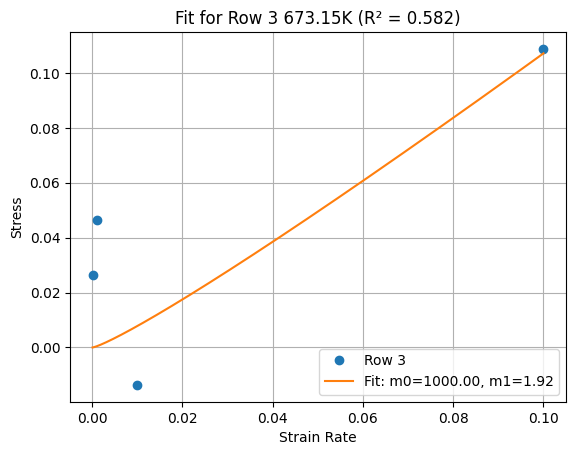

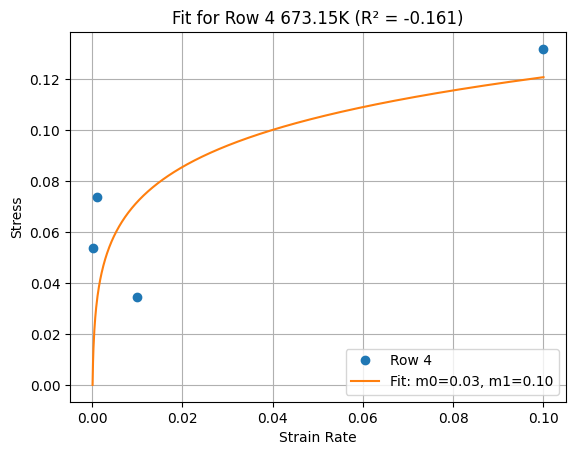

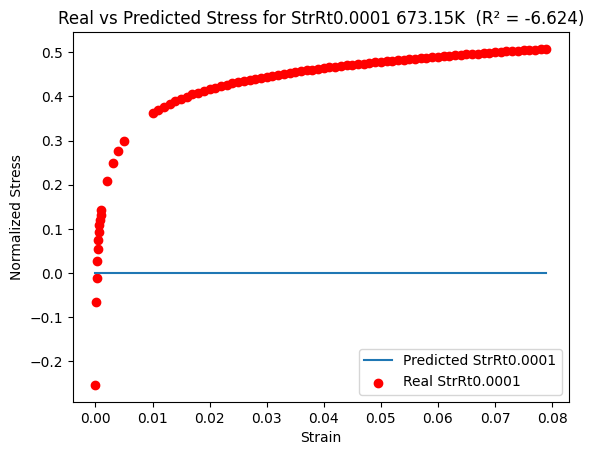

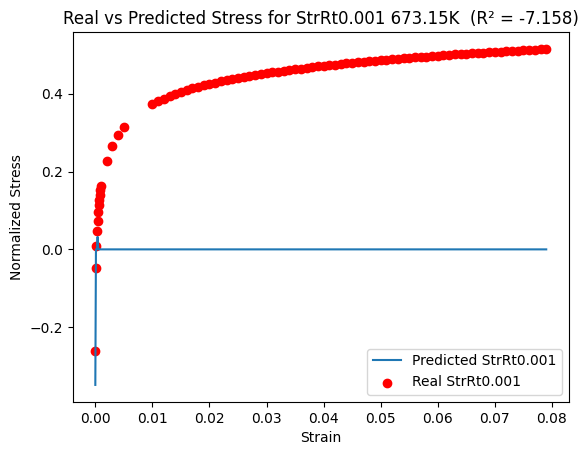

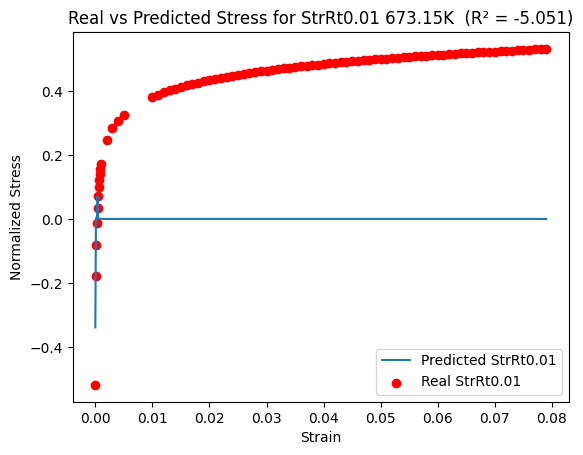

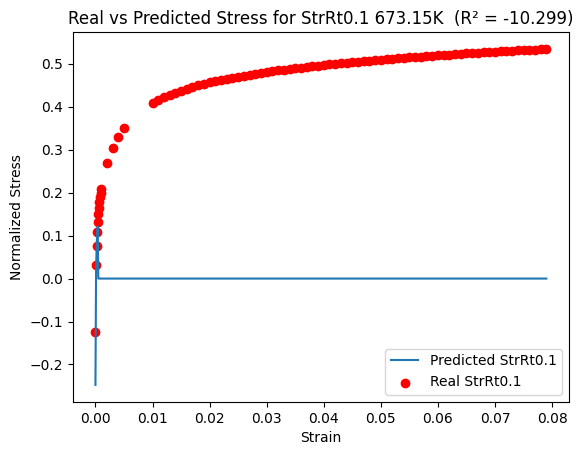

In [7]:
temp = '298.15'
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1, 1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
data = pd.read_csv(f"../Tmp{temp}_RD_fixed.csv")
estimate_m_values(data, temp, strain_rates, strain_rate_columns)


temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']

for temp in temps:
    data = pd.read_csv(f"../Tmp{temp}_RD_fixed.csv")
    estimate_m_values(data, temp, strain_rates, strain_rate_columns)
